# Spot Market Electricity Price Forecasting with Recurrent Neural Networks (RNNs)

## Author: Jack Burgemeister

# Abstract:
This project aims to demonstrate and analyse the feasibility of several state-of-the-art Recurrent Neural Network (RNN) Architectures to predict the Spot Market Electricity Price within South Australia. The RNNs tested within this project are:
* Standard RNN
* LSTM Variant
* GRU Variant

# Overview
0. Dataset
1. Pre-Processing
2. Training Methodology (Supporting Functions and Performance Metrics)
3. Baseline Model
4. RNN Architectures (Model Class Instantiation)  
  4.1 Standard RNN  
  4.2 LSTM-RNN  
  4.3 GRU-RNN  
5. Model Evaluation  
  5.1 Standard RNN  
  5.2 LSTM-RNN  
  5.3 GRU-RNN  
  5.4 Multi-Layer Standard RNN  
  5.5 Multi-Layer LSTM-RNN  
  5.6 Multi-Layer GRU-RNN  
6. Results Comparison

# Dataset:
The time-series dataset used throughout this study is the 5-minutely spot market price for South Australia as reported by AEMO. The daily reports can be viewed via `https://www.aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data`

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import requests

In [ ]:
# Constant Functions/Code
def set_seed():
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on ... {device}")

Running on ... cuda


# Section 0: Dataset
**1. Load Dataset from Source CSV.**  
**2. Data Visualisation.**

## 0.1 Load Dataset from Source CSV

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Datasets/sa_electricity/sa_electricity_price_25y.csv",parse_dates=["SETTLEMENTDATE"])
dataset = dataset[dataset["SETTLEMENTDATE"] >= pd.Timestamp("01-11-2021 00:05")].reset_index(drop=True) # Filtering for the Past Year of Data

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400320 entries, 0 to 400319
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  400320 non-null  datetime64[ns]
 1   RRP             400320 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.1 MB


In [ ]:
dataset.describe()

,SETTLEMENTDATE,RRP
count,400320,400320.000000
mean,2022-12-07 00:02:30.000000512,98.846933
min,2021-01-11 00:05:00,-1000.000000
25%,2021-12-24 12:03:45,7.826250
50%,2022-12-07 00:02:30,61.410000
75%,2023-11-19 12:01:15,130.800000
max,2024-11-01 00:00:00,17500.000000
std,NaN,450.264156


##0.2 Data Visualisation

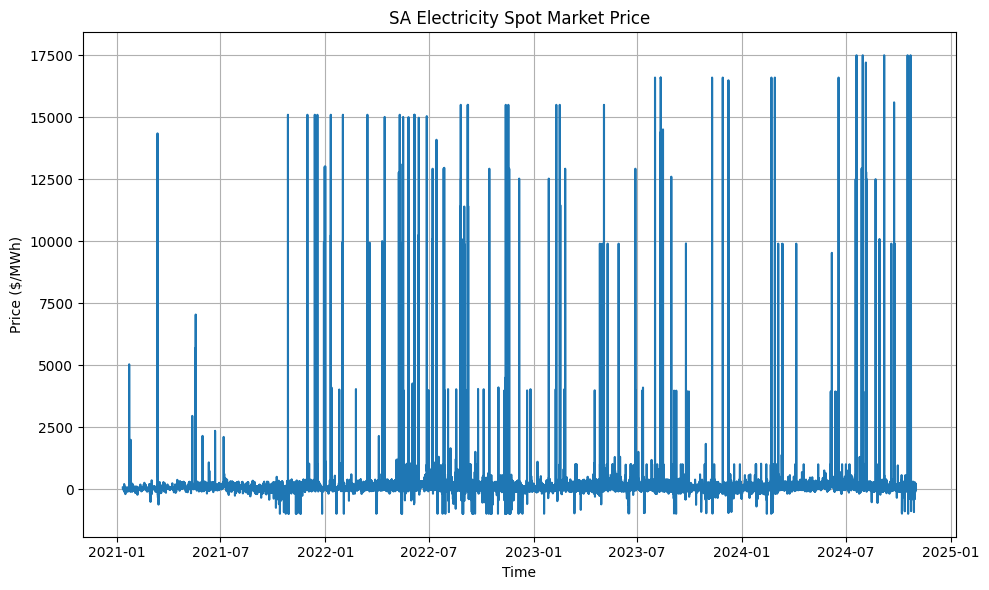

In [ ]:
# Standard Time-Series Line Plot
plt.figure(figsize=(10,6))
plt.plot(dataset["SETTLEMENTDATE"],dataset["RRP"])
plt.title("SA Electricity Spot Market Price")
plt.xlabel("Time")
plt.ylabel("Price ($/MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Section 1: Pre-Processing
**1. Sequencing** - Converting data into sequences of prescribed length.  
**2. Scaling** - Scaling the features to within a standardised limit learnable by the RNN.   
**3. Train/Val/Test Split** - Splitting the dataset into seperate sets.  
**4. DataLoaders** - Loading each dataset into torch DataLoader Objects.  
**5. Functionised Pipeline** - Functionising the pipeline so that it can be repeated simply for hyperparameter tuning.

## 1.1 Sequencing

In [ ]:
# Sequencing
set_seed()

def prepare_sequences(data, seq_length):
    df = data.copy()

    df.set_index("SETTLEMENTDATE", inplace=True)

    for i in range(1, seq_length + 1):
        df[f"RRP(t-{i})"] = df["RRP"].shift(i)

    df.dropna(inplace=True)

    return df

seq_length = 12
shifted_df = prepare_sequences(dataset, seq_length)
shifted_df_np = shifted_df.to_numpy()

## 1.2 Scaling
* MinMax Scaler

In [ ]:
# Scaling
set_seed()

x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

# Splitting X and Y - Flipping X so that t-1 is the last feature in the series
X = np.flip(shifted_df_np[:,1:],axis=1).copy()
y = shifted_df_np[:,0].reshape(-1,1)

# Applying Scaler
scaled_X = x_scaler.fit_transform(X)
scaled_y = y_scaler.fit_transform(y)

scaled_y = scaled_y.flatten()

## 1.3 Dataset Split
* Train/Val/Test = 0.7/0.15/0.15  

In [ ]:
# Determining Index Split for each Set
set_seed()

train_size = int(0.7 * len(scaled_X))
val_size = int(0.15 * len(scaled_y))
test_size = len(X) - train_size - val_size

# Dividing Train/Val/Test Sets
X_train = scaled_X[:train_size]
y_train = scaled_y[:train_size]

X_val = scaled_X[train_size:train_size+val_size]
y_val = scaled_y[train_size:train_size+val_size]

X_test = scaled_X[train_size+val_size:]
y_test = scaled_y[train_size+val_size:]

## 1.4 Dataset and DataLoader Objects
* Re-Shape and Convert to Tensors
* Instantiate Datasets
* Form into DataLoaders

In [ ]:
# Re-Shaping into Batches
set_seed()

X_train = X_train.reshape((-1, seq_length, 1))
X_val = X_val.reshape((-1, seq_length, 1))
X_test = X_test.reshape((-1, seq_length, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Converting to Tensors
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_val = torch.from_numpy(y_val).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
# Instantiating Datasets
class SpotPriceDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]

train_dataset = SpotPriceDataset(X_train,y_train)
val_dataset = SpotPriceDataset(X_val,y_val)
test_dataset = SpotPriceDataset(X_test,y_test)

In [ ]:
# Creating DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset,batch_size=batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

## 1.5 Functionised Pipeline
* Combing 1.1 to 1.4 into one function.

In [ ]:
# Functionised Pipeline
def prepare_dataloaders(df, batch_size, sequence_length):
    """
    Prepares train, validation, and test DataLoaders for time series data.

    Args:
        df (pd.DataFrame): Original dataset containing 'SETTLEMENTDATE' and 'RRP' columns.
        batch_size (int): Batch size for DataLoaders.
        sequence_length (int): Length of the input sequences.

    Returns:
        train_loader (DataLoader): DataLoader for training set.
        val_loader (DataLoader): DataLoader for validation set.
        test_loader (DataLoader): DataLoader for test set.
        y_scaler (MinMaxScaler): Scaler fitted on target variable (RRP).
    """

    # Sequence preparation
    df = df.copy()
    df.set_index("SETTLEMENTDATE", inplace=True)

    for i in range(1, sequence_length + 1):
        df[f"RRP(t-{i})"] = df["RRP"].shift(i)

    df.dropna(inplace=True)

    # Convert to numpy
    shifted_df_np = df.to_numpy()

    # Split X and y
    X = np.flip(shifted_df_np[:, 1:], axis=1).copy()
    y = shifted_df_np[:, 0].reshape(-1, 1)

    # Scaling
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_X = x_scaler.fit_transform(X)
    scaled_y = y_scaler.fit_transform(y)
    scaled_y = scaled_y.flatten()

    # Split data into train, val, test sets
    train_size = int(0.7 * len(scaled_X))
    val_size = int(0.15 * len(scaled_y))
    test_size = len(X) - train_size - val_size

    X_train = scaled_X[:train_size]
    y_train = scaled_y[:train_size]
    X_val = scaled_X[train_size:train_size + val_size]
    y_val = scaled_y[train_size:train_size + val_size]
    X_test = scaled_X[train_size + val_size:]
    y_test = scaled_y[train_size + val_size:]

    # Reshape into batches for RNNs
    X_train = X_train.reshape((-1, sequence_length, 1))
    X_val = X_val.reshape((-1, sequence_length, 1))
    X_test = X_test.reshape((-1, sequence_length, 1))

    y_train = y_train.reshape((-1, 1))
    y_val = y_val.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_train = torch.from_numpy(y_train).float()
    y_val = torch.from_numpy(y_val).float()
    y_test = torch.from_numpy(y_test).float()

    # Create datasets
    train_dataset = SpotPriceDataset(X_train, y_train)
    val_dataset = SpotPriceDataset(X_val, y_val)
    test_dataset = SpotPriceDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, y_scaler

# Section 2: Training Methodology
**1. Training Functions** - Training, Validation, Early Stopping.  
**2. Performance Metrics.** - R-Squared Value, Directional Accuracy.   
**3. Visualisation** - Loss Curves, Final Predictions.  
**4. Evaluation Function.** - Test.

## 2.1 Training Functions
* Training
* Validation
* Early Stopping

In [ ]:
# Training Function
def train_loop(
  model: nn.Module,
  train_loader: DataLoader,
  optimizer: torch.optim,
  loss_fn: nn.Module,
  device
  ):
  epoch_loss = 0.0

  model.train()
  for batch_idx, batch in tqdm(enumerate(train_loader)):
    X,y = batch[0].to(device),batch[1].to(device)

    # Evaluate Model
    y_pred = model(X)

    # Calculate Loss
    loss = loss_fn(y_pred,y)
    epoch_loss += loss.item()
    # print(f"Batch: {batch_idx+1} || Loss: {loss.item():.4}")

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer Step
    optimizer.step()

  return epoch_loss/len(train_loader)

In [ ]:
# Validation Function
def val_loop(
  model: nn.Module,
  val_loader: DataLoader,
  loss_fn: nn.Module,
  device
  ):
  epoch_loss = 0.0

  model.eval()
  with torch.inference_mode():
    for batch_idx, batch in enumerate(val_loader):
      X,y = batch[0].to(device),batch[1].to(device)

      # Evaluate Model
      y_pred = model(X)

      # Calculate Loss
      loss = loss_fn(y_pred,y)
      epoch_loss += loss.item()

  return epoch_loss/len(val_loader)

In [ ]:
# Early Stopping
class EarlyStopping:
  """
  Early Stopping to terminate training when the validation loss stops decreasing (w.r.t patience).
  """
  def __init__(self,
               patience: int = 5,
               delta: float = 0.0,
               save_path: str = "rnn_model.pth"):
    self.patience = patience
    self.delta = delta
    self.save_path = save_path
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model):
    """
    Check if Early Stopping Conditions have been met
    """
    if val_loss < self.best_loss - self.delta:
        self.best_loss = val_loss
        self.counter = 0
        self.save_checkpoint(model)
    else:
        self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True

  def save_checkpoint(self, model):
    """
    Saves the model's state_dict if loss is improved
    """
    torch.save(model.state_dict(), self.save_path)
    print(f"Validation loss improved. Saving model to {self.save_path}.")


## 2.2 Performance Metrics
* R^2 (Coefficient of Determination)  
* Directional Accuracy (DA)

In [ ]:
# R-Squared Coefficient
def calculate_r2(y_true, y_pred):
  """
  Calculates R-Squared Coefficient w.r.t the ground truth (y_true) and predicted values (y_pred).
  """
  ss_res = np.sum((y_true - y_pred) ** 2)
  ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
  r2 = 1 - (ss_res / ss_tot)
  return r2

In [ ]:
# Directional Accuracy
def calculate_da(y_true, y_pred):
  """
  Calculates Directional Accuracy w.r.t the ground truth (y_true) and predicted values (y_pred).
  """
  true_direc = np.sign(np.diff(y_true))[1:]
  pred_direc = np.sign(np.diff(y_pred))[1:]
  correct_direc = np.sum(true_direc == pred_direc)

  return correct_direc / len(true_direc)

## 2.3 Visualisation Functions
* Loss Curves
* Final Predictions
* Comparison of Final Predictions (For Multiple Models)

In [ ]:
# Plot Loss Curves
def plot_loss_curves(train_loss: list,
                     val_loss: list,
                     model_string: str = "RNN Model"):
  """
  This function takes lists of training and validation losses and plots them on a standard figure.
  """
  epochs = np.arange(1,len(train_loss)+1)
  plt.figure(figsize=(10,6))
  plt.plot(epochs,train_loss,label="Training Loss", color = "forestgreen")
  plt.plot(epochs,val_loss,label="Validation Loss", color = "tomato")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"{model_string}: Loss Curves")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  plt.savefig(f'/content/drive/MyDrive/Datasets/sa_electricity/Charts/loss_curves_{model_string}.svg')

  plt.show()

In [ ]:
# Plot Predictions
def plot_predictions(y_pred,y_true,title_string):
  """
  This function takes a set of ground truth and predicted prices and plots them on a time series graph
  """
  # Reverse-Engineer Time-Series
  time_series = dataset["SETTLEMENTDATE"].tolist()

  time_series_all = pd.to_datetime(time_series[-8640:])
  time_series_1w = pd.to_datetime(time_series[-2016:])
  time_series_1d = pd.to_datetime(time_series[-288:])

  # Plot Predictions
  plt.subplots(3,1,figsize=(10,9),sharex = False)

  # All Test Set
  plt.subplot(3,1,1)
  plt.plot(time_series_all,y_true[-8640:],label="Actual",color="royalblue",alpha=0.9)
  plt.plot(time_series_all,y_pred[-8640:],label="Predicted",color="darkorange", alpha = 0.9)
  plt.xlabel("Time")
  plt.xlim(time_series_all[0],time_series_all[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  plt.legend()
  # plt.title(f"{title_string}: Test Set Predictions - All")
  plt.title("Last 30 Days")

  # 1 Week
  plt.subplot(3,1,2)
  plt.plot(time_series_1w,y_true[-2016:],label="Actual",color="royalblue",alpha=0.9)
  plt.plot(time_series_1w,y_pred[-2016:],label="Predicted",color="darkorange", alpha = 0.9)
  plt.xlabel("Time")
  plt.xlim(time_series_1w[0],time_series_1w[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  plt.legend()
  # plt.title(f"{title_string}: Test Set Predictions - Last 7 Days")
  plt.title("Last 7 Days")

  # 1 Day
  plt.subplot(3,1,3)
  plt.plot(time_series_1d,y_true[-288:],label="Actual",color="royalblue",alpha=0.9)
  plt.plot(time_series_1d,y_pred[-288:],label="Predicted",color="darkorange", alpha = 0.9)
  plt.xlabel("Time")
  plt.xlim(time_series_1d[0],time_series_1d[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  plt.legend()
  # plt.title(f"{title_string}: Test Set Predictions - Last 24 Hours")
  plt.title("Last 24 Hours")

  plt.suptitle(f"{title_string}: Predicted vs Actual Test Set Price", fontsize ="x-large")

  plt.tight_layout()

  plt.savefig(f"/content/drive/MyDrive/Datasets/sa_electricity/Charts/predictions_{title_string}.svg")

  plt.show()

  return plt

In [ ]:
# Plot Predictions for Model Comparison
def plot_predictions_model_comp(predictions: dict): # Dict in form {"Model Name":([y_preds],[y_true])}
  """
  This function takes a set of ground truth and predicted prices and plots them on a time series graph
  """
  # Reverse-Engineer Time-Series
  time_series = dataset["SETTLEMENTDATE"].tolist()

  time_series_all = pd.to_datetime(time_series[-8640:])
  time_series_1w = pd.to_datetime(time_series[-2016:])
  time_series_1d = pd.to_datetime(time_series[-288:])

  # Attain Ground True Set
  first_key = next(iter(predictions))
  _ , y_true = predictions[first_key]

  # Plot Predictions
  plt.subplots(3,1,figsize=(10,9),sharex = False)

  # 30 Days
  plt.subplot(3,1,1)
  plt.plot(time_series_all,y_true[-8640:],label="Actual",linewidth = 2)
  for model_name, (y_pred,y_true) in predictions.items():
    plt.plot(time_series_all,y_pred[-8640:],label=model_name,linestyle = (0,(0.1,2)),dash_capstyle = "round",linewidth = 2)
  plt.xlabel("Time")
  plt.xlim(time_series_all[0],time_series_all[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  plt.legend()
  plt.title("Last 30 Days")

  # 1 Week
  plt.subplot(3,1,2)
  plt.plot(time_series_1w,y_true[-2016:],linewidth = 2)
  for model_name, (y_pred,y_true) in predictions.items():
    plt.plot(time_series_1w,y_pred[-2016:],linestyle = (0,(0.1,2)),dash_capstyle = "round",linewidth = 2)
  plt.xlabel("Time")
  plt.xlim(time_series_1w[0],time_series_1w[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  # plt.title(f"{title_string}: Test Set Predictions - Last 7 Days")
  plt.title("Last 7 Days")

  # 1 Day
  plt.subplot(3,1,3)
  plt.plot(time_series_1d,y_true[-288:],linewidth = 2)
  for model_name, (y_pred,y_true) in predictions.items():
    plt.plot(time_series_1d,y_pred[-288:],linestyle = (0,(0.1,2)),dash_capstyle = "round",linewidth = 2)
  plt.xlabel("Time")
  plt.xlim(time_series_1d[0],time_series_1d[-1])
  plt.ylabel("Price ($/MWh)")
  plt.grid(True)
  # plt.title(f"{title_string}: Test Set Predictions - Last 24 Hours")
  plt.title("Last 24 Hours")

  plt.suptitle("RNN Model Comparison: Predicted vs Actual Test Set Price", fontsize ="x-large")

  plt.tight_layout()

  plt.savefig('/content/drive/MyDrive/Datasets/sa_electricity/Charts/final_predictions.svg')

  plt.show()



## 2.4 Model Evaluation
* Evaluation Function

In [ ]:
# Evaluation Function on Test Set
def eval_loop(
    model: nn.Module,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    device,
    scaler,
    mode: int = 0, # 0 = Default Plot Predictions Mode, 1 = Return Predictions for Combined Plot
    title_string: str = "RNN Model"):

    """
    This function evaluates the passed model upon each batch within the test data_loader w.r.t the loss function, then plots the predictions and returns the summarised results.
    """

    epoch_loss = 0.0
    y_preds = list()
    y_tests = list()

    model.eval()
    with torch.inference_mode():
        for batch_idx, batch in enumerate(test_loader):
            X, y = batch[0].to(device), batch[1].to(device)

            # Evaluate Model
            y_pred = model(X)

            # Store Predictions vs Actual Values
            y_preds.extend(y_pred.cpu().numpy().flatten())
            y_tests.extend(y.cpu().numpy().flatten())

            # Calculate Loss
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    # Convert lists to NumPy arrays
    y_preds = np.array(y_preds).reshape(-1, 1)
    y_tests = np.array(y_tests).reshape(-1, 1)

    # Revert scaled values to their original scale
    y_preds_original = scaler.inverse_transform(y_preds)
    y_tests_original = scaler.inverse_transform(y_tests)

    # Scaled MSE Loss
    X_test = dataset["RRP"].tolist()
    X_test = X_test[train_size+val_size:]

    results = {
        "Model": title_string,
        "MSE Loss": np.round(epoch_loss, 4),
        "Scaled MSE Loss ($/MWh)": np.round(epoch_loss * (np.max(X_test) - np.min(X_test)), 4),
        "R^2": np.round(calculate_r2(y_tests_original.flatten(), y_preds_original.flatten()), 4),
        "Directional Accuracy": np.round(calculate_da(y_tests_original.flatten(), y_preds_original.flatten()), 4)
    }

    plot_predictions(y_pred=y_preds_original.flatten(),
                y_true=y_tests_original.flatten(),
                title_string=title_string)

    if mode == 0: # Default Mode - Plot Predictions
      return results
    else:
      preds = (y_preds_original.flatten(),y_tests_original.flatten())
      return results, preds

# Section 3: Baseline Model
This section defines, trains, and evalutes a baseline model to ensure all training methodology has been correctly implemented. The subsections are structured as follows:
**1. Model Definition.**  
**2. Model Training.**  
**3. Model Evaluation.**

## 3.1 Model Definition

In [ ]:
# Model Definition
class Baseline_RNN(nn.Module):
    def __init__(self,
                 input_size: int = 1, # Number of Expected Features within the Input
                 hidden_size: int = 5, # Number of Features in Hidden State
                 num_layers: int = 1 # Number of Recurrent Layers (e.g. stacked RNNs)
                 ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.rnn(x,h0)
        out = self.fc(out[:, -1, :])
        return out

## 3.2 Model Training

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.2476 || Validation Loss: 0.1136 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.04804 || Validation Loss: 0.01263 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.004668 || Validation Loss: 0.001459 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001698 || Validation Loss: 0.001064 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001636 || Validation Loss: 0.001049 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001629 || Validation Loss: 0.001044 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.00162 || Validation Loss: 0.001039 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001609 || Validation Loss: 0.001034 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001595 || Validation Loss: 0.001029 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001579 || Validation Loss: 0.001024 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.00156 || Validation Loss: 0.001015 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001538 || Validation Loss: 0.001004 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001515 || Validation Loss: 0.0009919 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001491 || Validation Loss: 0.0009785 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 15 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001465 || Validation Loss: 0.0009647 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 16 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001438 || Validation Loss: 0.0009507 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 17 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001411 || Validation Loss: 0.0009366 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 18 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001385 || Validation Loss: 0.0009226 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 19 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001358 || Validation Loss: 0.000909 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.
Epoch: 20 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001332 || Validation Loss: 0.0008958 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth.


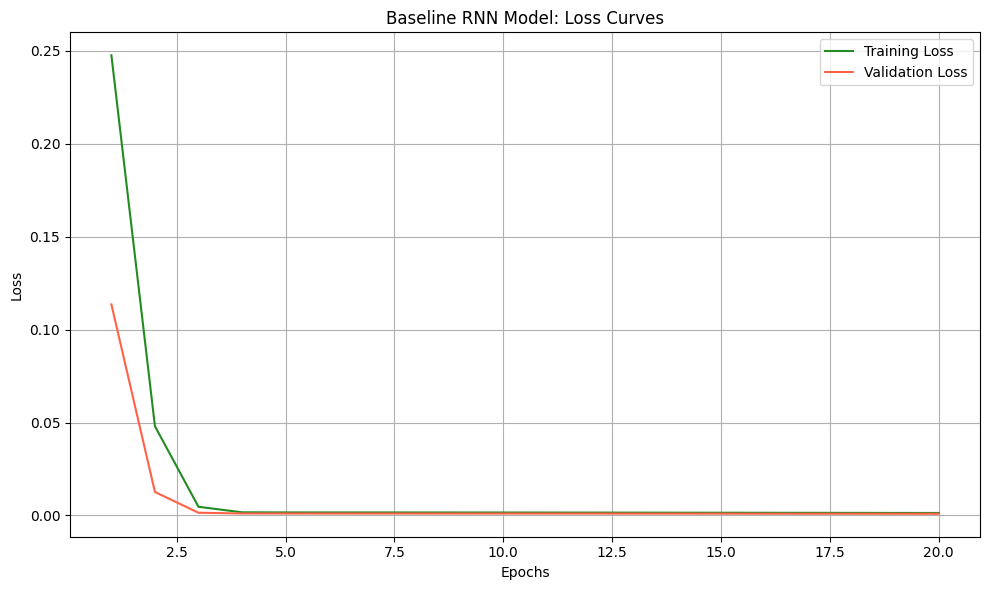

In [ ]:
# Model Training
set_seed()

# Hyperparameters
model = Baseline_RNN().to(device)
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/baseline_rnn_model.pth"
early_stopping = EarlyStopping(patience = 5, delta = 1e-6, save_path = model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1} \n---------")
  train_loss.append(train_loop(model=model,
                          train_loader=train_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          device=device))
  val_loss.append(val_loop(model=model,
                      val_loader=val_loader,
                      loss_fn=loss_fn,
                      device=device))

  print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

  # LR Scheduling
  lr_sched.step(val_loss[-1])

  # Check/Trigger Early Stopping
  early_stopping(val_loss[-1],model)
  if early_stopping.early_stop:
    print("Early Stopping Triggered, Stopping Training ...")
    break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only = True))

# Plot Loss Curves
plot_loss_curves(train_loss = train_loss, val_loss = val_loss, model_string = "Baseline RNN Model")

## 3.3 Model Evaluation

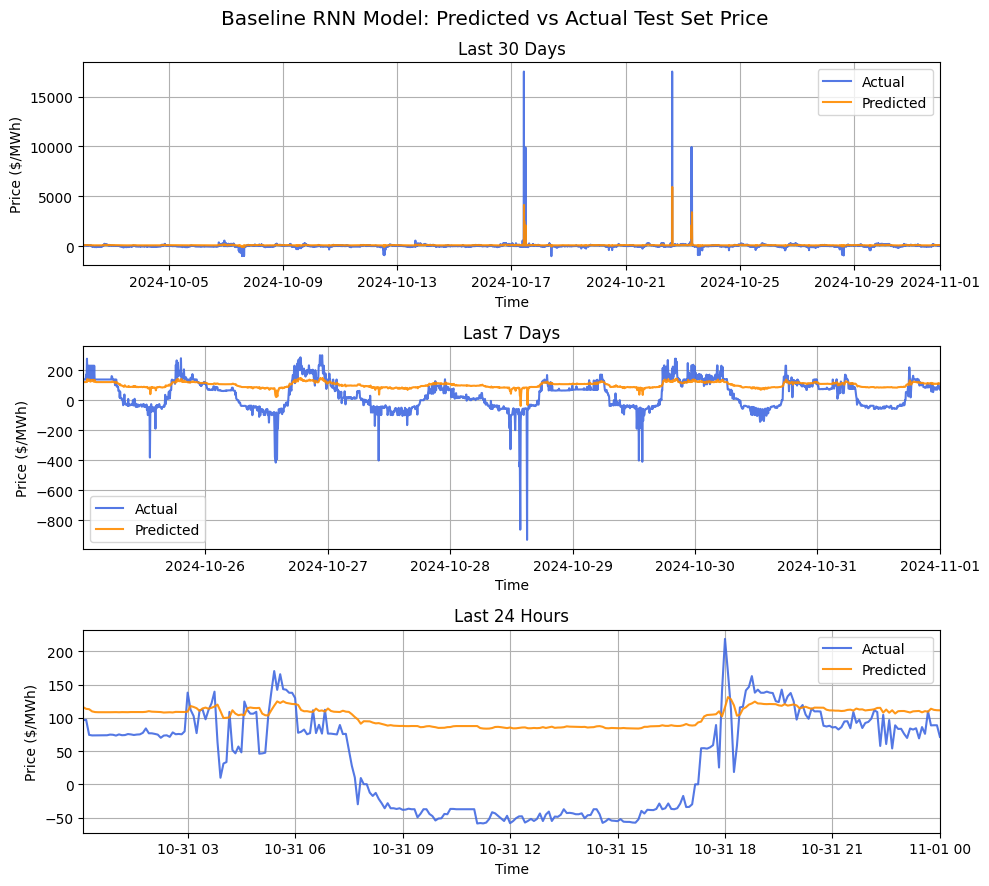

,Model,MSE Loss,Scaled MSE Loss ($/MWh),R^2,Directional Accuracy
0,Baseline RNN Model,0.0029,53.5564,0.4128,0.3656


In [ ]:
baseline_results, baseline_preds = eval_loop(model = model,
          test_loader = test_loader,
          loss_fn = loss_fn,
          device = device,
          scaler = y_scaler,
          mode = 1,
          title_string = "Baseline RNN Model")
baseline_df = pd.DataFrame(baseline_results,index=[0])
baseline_df

# Section 4: RNN Architectures
This section will define the instantiation of three RNN Architectures:  
**1. Standard RNN**  
**2. Long Short-Term Memory RNN**  
**3. Gate Recurrent Unit RNN**  

Each RNN class is designed to be configured as both a single-layer and multi-layer RNN.


### 4.1 Standard RNN

In [ ]:
# Model Definition
class RNN(nn.Module):
    def __init__(self,
                 input_size: int = 1, # Number of Expected Features within the Input
                 hidden_size: int = 5, # Number of Neurons in Hidden State
                 num_layers: int = 1, # Number of Recurrent Layers (e.g. stacked RNNs)
                 dropout_rate: float = 0.5,
                 bidirectional: bool = False
                 ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.rnn = nn.RNN(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          dropout = dropout_rate if num_layers > 1 else 0,
                          bidirectional = bidirectional,
                          batch_first=True)

        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

        self.initialise_weights()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)

        out, _ = self.rnn(x,h0)
        out = self.fc(out[:, -1, :])
        return out

    def initialise_weights(self):
      """
      Initialises RNN Parameters per the He Initialisation Method

      """
      for name, param in self.named_parameters():
        if 'weight_ih' in name or 'weight_hh' in name: #Input to Hidden or Hidden to Hidden Weights
          nn.init.kaiming_uniform_(param, nonlinearity="tanh")
        elif 'weight' in name: # Fully-Connected Layer Weights
            nn.init.kaiming_uniform_(param, nonlinearity="relu")
        elif "bias" in name: # Initialising Biases in Both Layers
          nn.init.zeros_(param)


### 4.2 Long Short-Term Memory (LSTM) RNN



In [ ]:
# Model Definition
class LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 1, # Number of Expected Features within the Input
                 hidden_size: int = 5, # Number of Neurons in Hidden State
                 num_layers: int = 1, # Number of Recurrent Layers (e.g. stacked RNNs)
                 dropout_rate: float = 0.5, # Drop-Out Rate (Only in effect for multi-layered networks as it is applied between layers)
                 bidirectional: bool = False
                 ):
      super().__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.num_directions = 2 if bidirectional else 1

      self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout_rate if num_layers > 1 else 0,
                        bidirectional = bidirectional,
                        batch_first=True)

      self.fc = nn.Linear(hidden_size * self.num_directions, 1)

      self.initialise_weights()

    def forward(self, x):
      """
      Performs Forward Pass for the LSTM Model
      """
      batch_size = x.size(0)

      h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
      c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)

      out, _ = self.lstm(x,(h0,c0))
      out = self.fc(out[:, -1, :])
      return out

    def initialise_weights(self):
      """
      Initialises Model Parameters per the Xavier Initialisation Method for LSTM weights, and He Initialisation Method for Fully-Connected Layer Weights.

      """
      for name, param in self.named_parameters():
        if 'weight_ih' in name or 'weight_hh' in name: #Input to Hidden or Hidden to Hidden Weights
          nn.init.xavier_uniform_(param)
        elif 'weight' in name: # Fully-Connected Layer Weights
            nn.init.kaiming_uniform_(param, nonlinearity="relu")
        elif "bias" in name: # Initialising Biases in Both Layers
          nn.init.zeros_(param)

### 4.3 Gate-Reccurent Unit (GRU) RNN

In [ ]:
# Model Definition
class GRU(nn.Module):
    def __init__(self,
                 input_size: int = 1, # Number of Expected Features within the Input
                 hidden_size: int = 5, # Number of Neurons in Hidden State
                 num_layers: int = 1, # Number of Recurrent Layers (e.g. stacked RNNs)
                 dropout_rate: float = 0.5, # Drop-Out Rate (Only in effect for multi-layered networks as it is applied between layers)
                 bidirectional: bool = False
                 ):
      super().__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.num_directions = 2 if bidirectional else 1

      self.gru = nn.GRU(input_size = input_size,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout_rate if num_layers > 1 else 0,
                        bidirectional = bidirectional,
                        batch_first=True)

      self.fc = nn.Linear(hidden_size * self.num_directions, 1)

      self.initialise_weights()

    def forward(self, x):
      """
      Performs Forward Pass for the GRU Model
      """
      batch_size = x.size(0)

      h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)

      out, _ = self.gru(x,h0)
      out = self.fc(out[:, -1, :])
      return out

    def initialise_weights(self):
      """
      Initialises Model Parameters:
      - Xavier Initiliasation for GRU Parameters (Sigmoid Activation Function) per the Xavier Initialisation Method for GRU weights, and He Initialisation Method for Fully-Connected Layer Weights.

      """
      for name, param in self.named_parameters():
        if 'weight_ih' in name or 'weight_hh' in name: #Input to Hidden or Hidden to Hidden Weights
          nn.init.xavier_uniform_(param)
        elif 'weight' in name: # Fully-Connected Layer Weights
            nn.init.kaiming_uniform_(param, nonlinearity="relu")
        elif "bias" in name: # Initialising Biases in Both Layers
          nn.init.zeros_(param)

# Section 5: Model Evaluation
This sub-section will evaluate each model with respect to the following hyperparameters:

Single-Layer Models
* Sequence Length = 12
* Batch Size = 32
* Learning Rate = 0.0001
* Optimizer = Adam
* Hidden Units = 16

Multi-Layer Models
* Sequence Length = 12
* Batch Size = 32
* Learning Rate = 0.0001
* Optimizer = Adam
* Hidden Units = 64
* Number of Layers = 3
* Dropout Rate = 0.1

In [ ]:
# Single-Layer Params
params = {
    "input_size": 1,
    "hidden_size": 8,
    "num_layers": 1,
    "epochs": 100,
    "optimizer": torch.optim.Adam,
    "lr": 0.0001,
    "loss_fn": nn.MSELoss(),
    "sequence_length": 12,
    "batch_size": 32
}

# Multi-Layer Params
m_params = {
    "input_size": 1,
    "hidden_size": 64,
    "num_layers": 3,
    "epochs": epochs,
    "optimizer": torch.optim.Adam,
    "lr": 0.0001,
    "loss_fn": nn.MSELoss(),
    "sequence_length": 12,
    "batch_size": 32,
    "dropout_rate": 0.1
}

In [ ]:
set_seed()
train_loader, val_loader, test_loader, y_scaler = prepare_dataloaders(dataset, params["batch_size"], params["sequence_length"])

## 5.1 Standard RNN

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.01728 || Validation Loss: 0.002461 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.002807 || Validation Loss: 0.001071 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001329 || Validation Loss: 0.0007493 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001065 || Validation Loss: 0.0006714 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001002 || Validation Loss: 0.000655 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009759 || Validation Loss: 0.0006393 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009621 || Validation Loss: 0.0006354 

Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009553 || Validation Loss: 0.0006467 

Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000949 || Validation Loss: 0.0006374 

Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009451 || Validation Loss: 0.0006426 

Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0009403 || Validation Loss: 0.0006503 

Early Stopping Triggered, Stopping Training ...


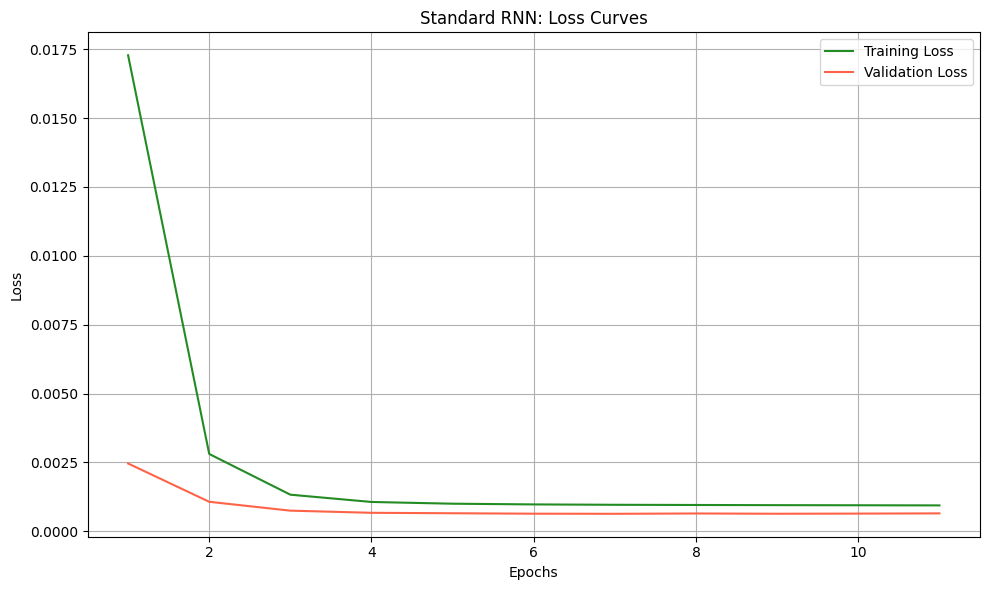

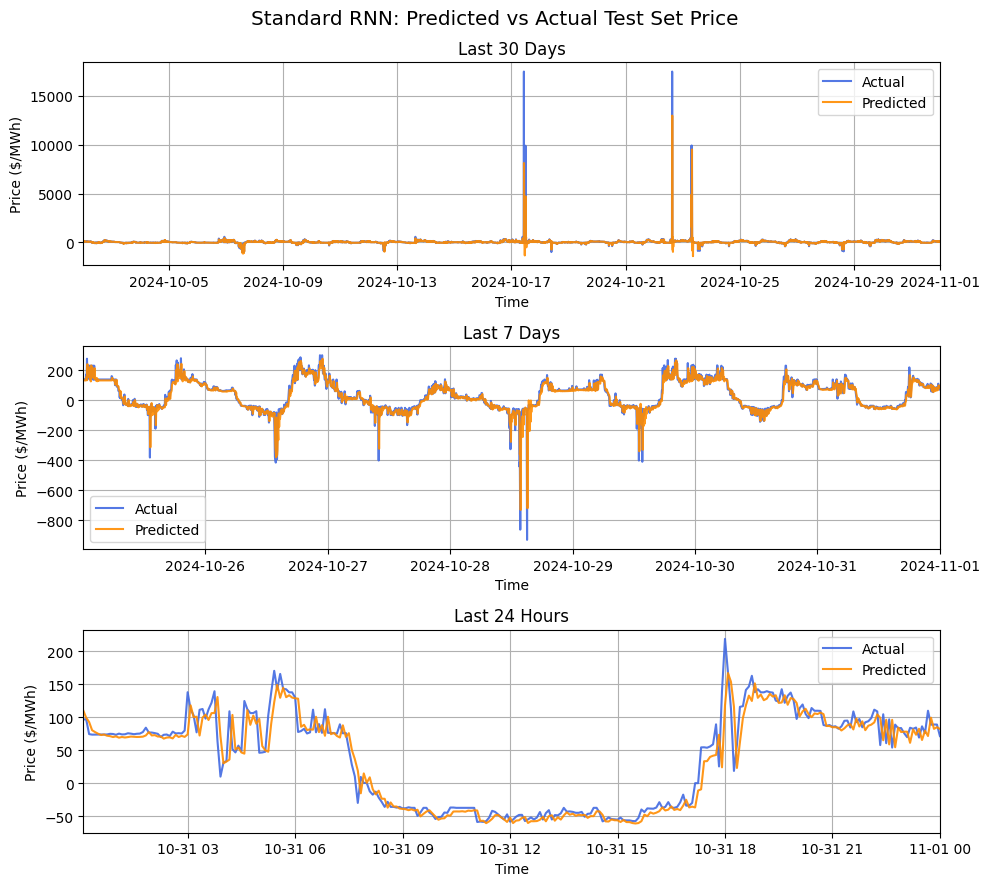

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = RNN(input_size=params["input_size"],
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"]).to(device)

epochs = params["epochs"]
optimizer = params["optimizer"](model.parameters(), lr=params["lr"])
loss_fn = params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_rnn_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-5, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"Standard RNN")

# Evaluate Model
std_rnn_results, std_rnn_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"Standard RNN")

## 5.2 LSTM RNN

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.004561 || Validation Loss: 0.000743 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009762 || Validation Loss: 0.0007287 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009628 || Validation Loss: 0.0007188 

Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009552 || Validation Loss: 0.0007061 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009502 || Validation Loss: 0.0006993 

Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000946 || Validation Loss: 0.0006933 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009429 || Validation Loss: 0.000802 

Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009405 || Validation Loss: 0.0007215 

Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009385 || Validation Loss: 0.0006783 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009356 || Validation Loss: 0.0006744 

Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009336 || Validation Loss: 0.0006749 

Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009321 || Validation Loss: 0.0006674 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009303 || Validation Loss: 0.0006649 

Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009291 || Validation Loss: 0.0006641 

Epoch: 15 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009275 || Validation Loss: 0.0006603 

Epoch: 16 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009267 || Validation Loss: 0.0006582 

Epoch: 17 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009245 || Validation Loss: 0.0006569 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth.
Epoch: 18 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009235 || Validation Loss: 0.0006569 

Epoch: 19 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009229 || Validation Loss: 0.0006585 

Epoch: 20 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009211 || Validation Loss: 0.0006549 

Epoch: 21 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009206 || Validation Loss: 0.0006525 

Epoch: 22 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009197 || Validation Loss: 0.0006526 

Early Stopping Triggered, Stopping Training ...


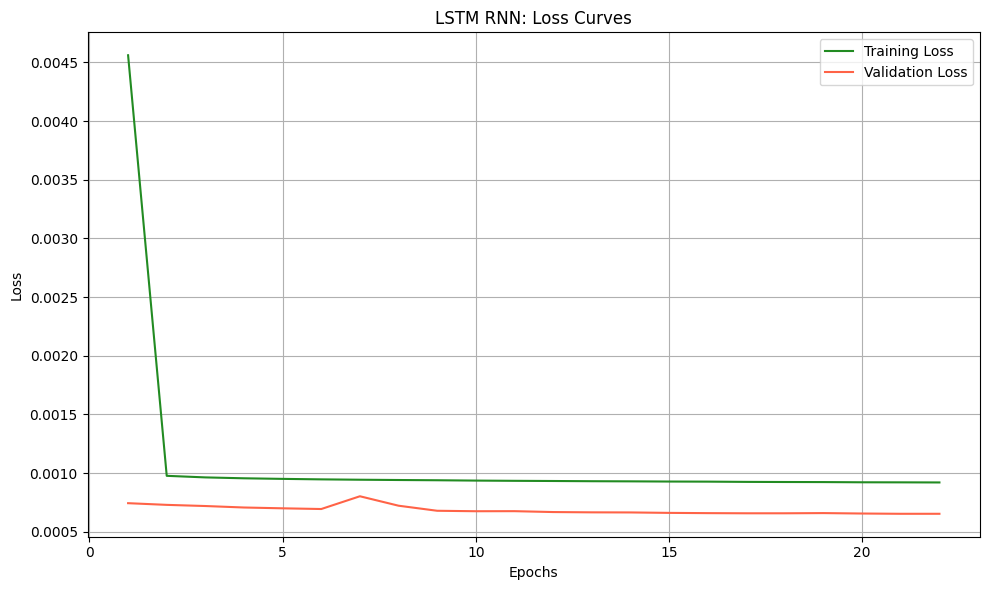

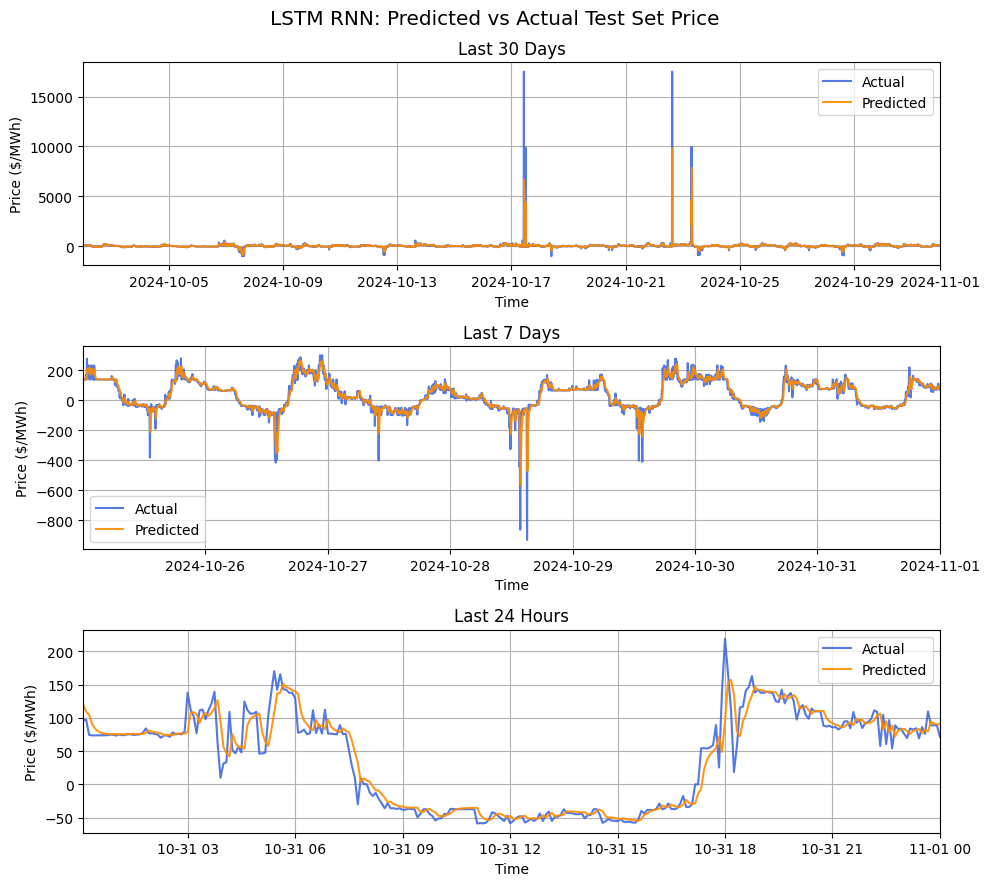

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = LSTM(input_size=params["input_size"],
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"]).to(device)

epochs = params["epochs"]
optimizer = params["optimizer"](model.parameters(), lr=params["lr"])
loss_fn = params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_lstm_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-5, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"LSTM RNN")

# Evaluate Model
lstm_rnn_results, lstm_rnn_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"LSTM RNN")

## 5.3 GRU RNN

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.06677 || Validation Loss: 0.00103 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001197 || Validation Loss: 0.0008419 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001044 || Validation Loss: 0.0007706 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009955 || Validation Loss: 0.0007359 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009734 || Validation Loss: 0.0007137 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009608 || Validation Loss: 0.0006966 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009511 || Validation Loss: 0.0006918 

Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009449 || Validation Loss: 0.0006785 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009398 || Validation Loss: 0.0006985 

Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009355 || Validation Loss: 0.0006751 

Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009319 || Validation Loss: 0.0006706 

Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000929 || Validation Loss: 0.000661 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth.
Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009252 || Validation Loss: 0.0006567 

Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009241 || Validation Loss: 0.0006555 

Epoch: 15 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009212 || Validation Loss: 0.0006661 

Epoch: 16 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009191 || Validation Loss: 0.0006555 

Epoch: 17 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009174 || Validation Loss: 0.0006559 

Early Stopping Triggered, Stopping Training ...


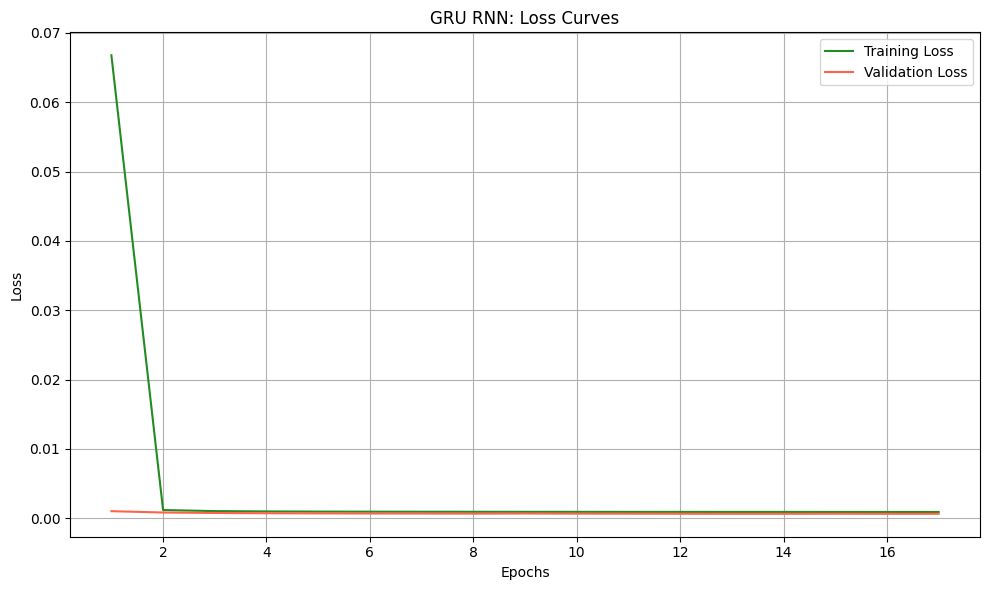

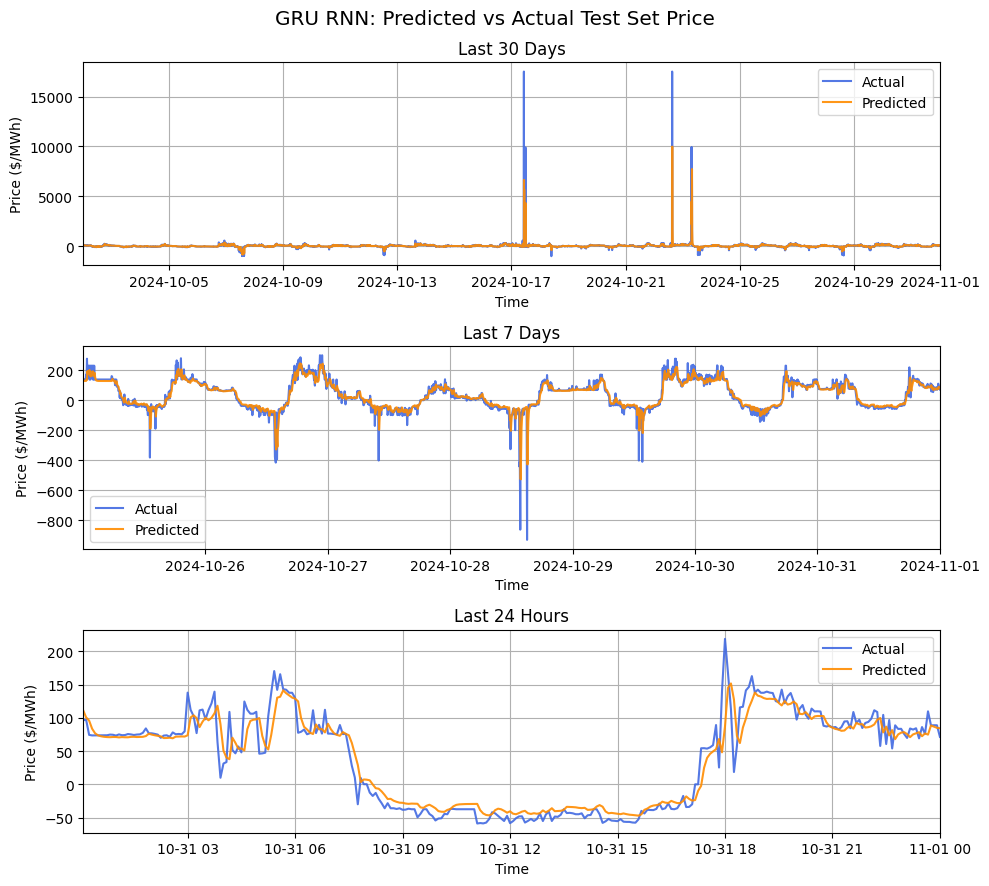

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = GRU(input_size=params["input_size"],
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"]).to(device)

epochs = params["epochs"]
optimizer = params["optimizer"](model.parameters(), lr=params["lr"])
loss_fn = params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_gru_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-5, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"GRU RNN")

# Evaluate Model
gru_rnn_results, gru_rnn_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"GRU RNN")

## 5.4 Multi-Layer Standard RNN

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.01172 || Validation Loss: 0.0009673 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001621 || Validation Loss: 0.0008335 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001421 || Validation Loss: 0.0008607 

Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001313 || Validation Loss: 0.0008245 

Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001185 || Validation Loss: 0.0007828 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001118 || Validation Loss: 0.0007659 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001084 || Validation Loss: 0.0007646 

Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001009 || Validation Loss: 0.0008171 

Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009865 || Validation Loss: 0.0008049 

Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009456 || Validation Loss: 0.000755 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000958 || Validation Loss: 0.0007217 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009419 || Validation Loss: 0.0007239 

Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009277 || Validation Loss: 0.0007387 

Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009103 || Validation Loss: 0.0007192 

Epoch: 15 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008876 || Validation Loss: 0.0006849 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth.
Epoch: 16 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008804 || Validation Loss: 0.0006958 

Epoch: 17 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008649 || Validation Loss: 0.0007445 

Epoch: 18 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008806 || Validation Loss: 0.0007093 

Epoch: 19 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0008582 || Validation Loss: 0.0007247 

Epoch: 20 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0008084 || Validation Loss: 0.0007175 

Early Stopping Triggered, Stopping Training ...


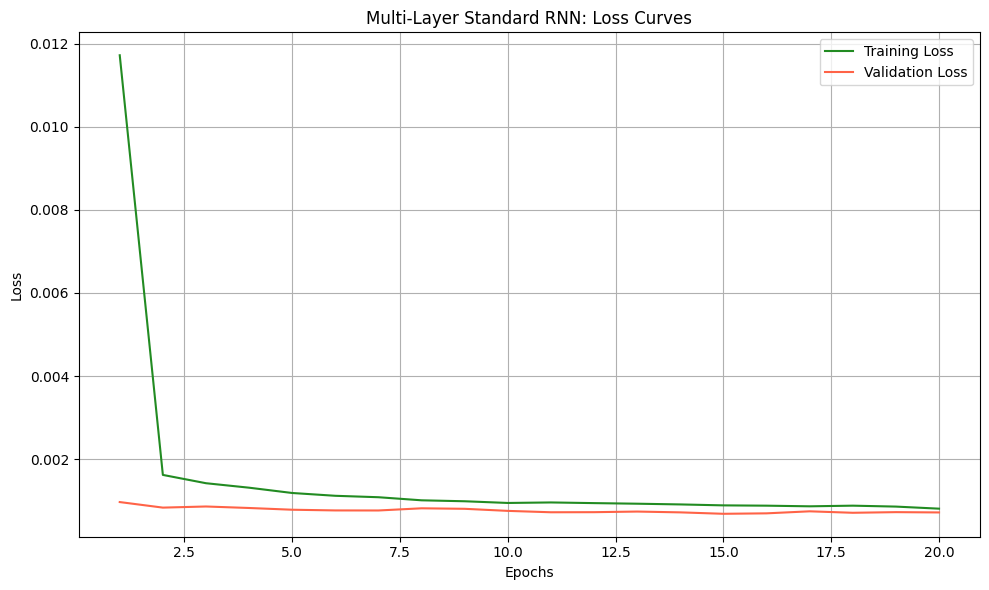

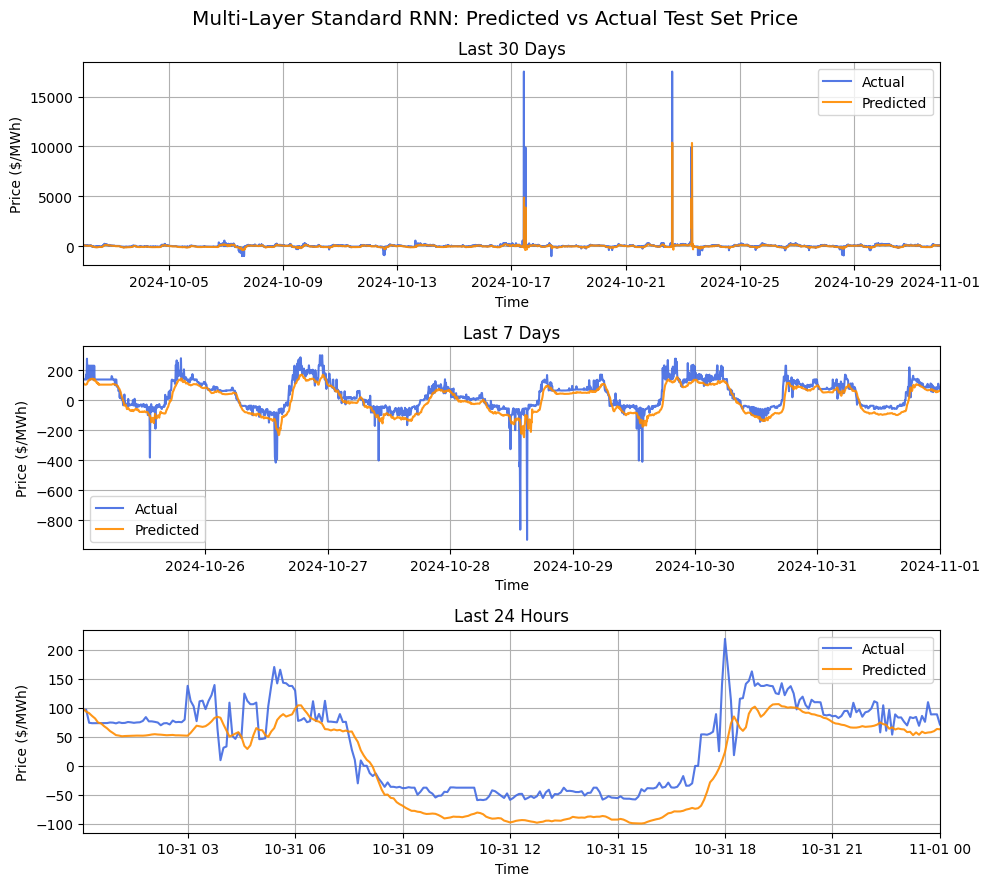

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = RNN(input_size=m_params["input_size"],
            hidden_size=m_params["hidden_size"],
            num_layers=m_params["num_layers"],
            dropout_rate=m_params["dropout_rate"]).to(device)

epochs = m_params["epochs"]
optimizer = m_params["optimizer"](model.parameters(), lr=m_params["lr"])
loss_fn = m_params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_rnn_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-5, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"Multi-Layer Standard RNN")

# Evaluate Model
m_std_rnn_results, m_std_rnn_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"Multi-Layer Standard RNN")

## 5.5 Multi-Layer LSTM

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.00589 || Validation Loss: 0.001112 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001347 || Validation Loss: 0.0009253 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001125 || Validation Loss: 0.0008868 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001008 || Validation Loss: 0.0006895 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009643 || Validation Loss: 0.0006506 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000961 || Validation Loss: 0.0006522 

Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009525 || Validation Loss: 0.0006468 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009474 || Validation Loss: 0.0006327 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009481 || Validation Loss: 0.0006313 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth.
Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009376 || Validation Loss: 0.0006829 

Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009416 || Validation Loss: 0.0006579 

Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009369 || Validation Loss: 0.000709 

Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0009443 || Validation Loss: 0.0006441 

Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0009077 || Validation Loss: 0.000643 

Early Stopping Triggered, Stopping Training ...


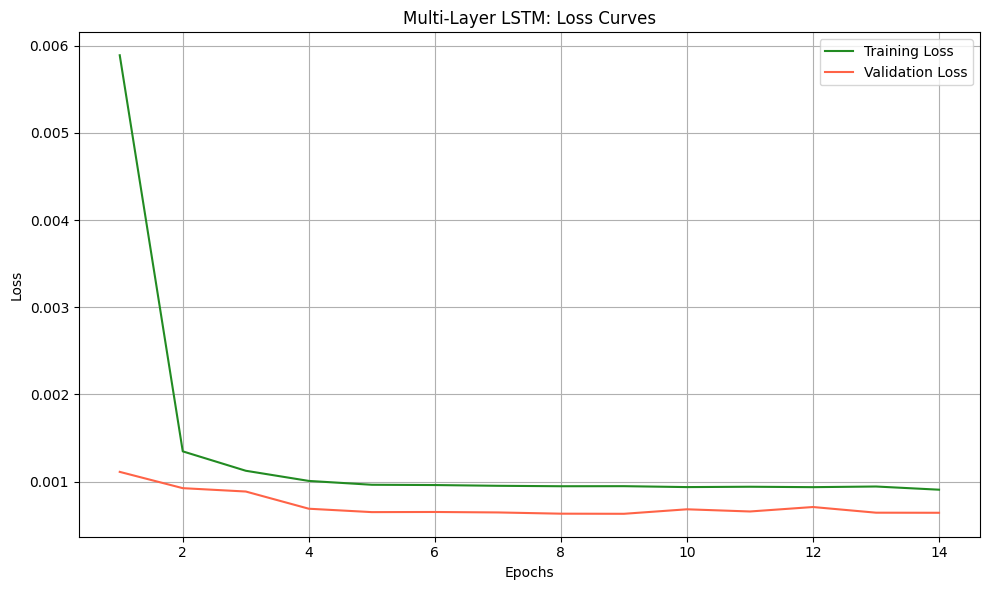

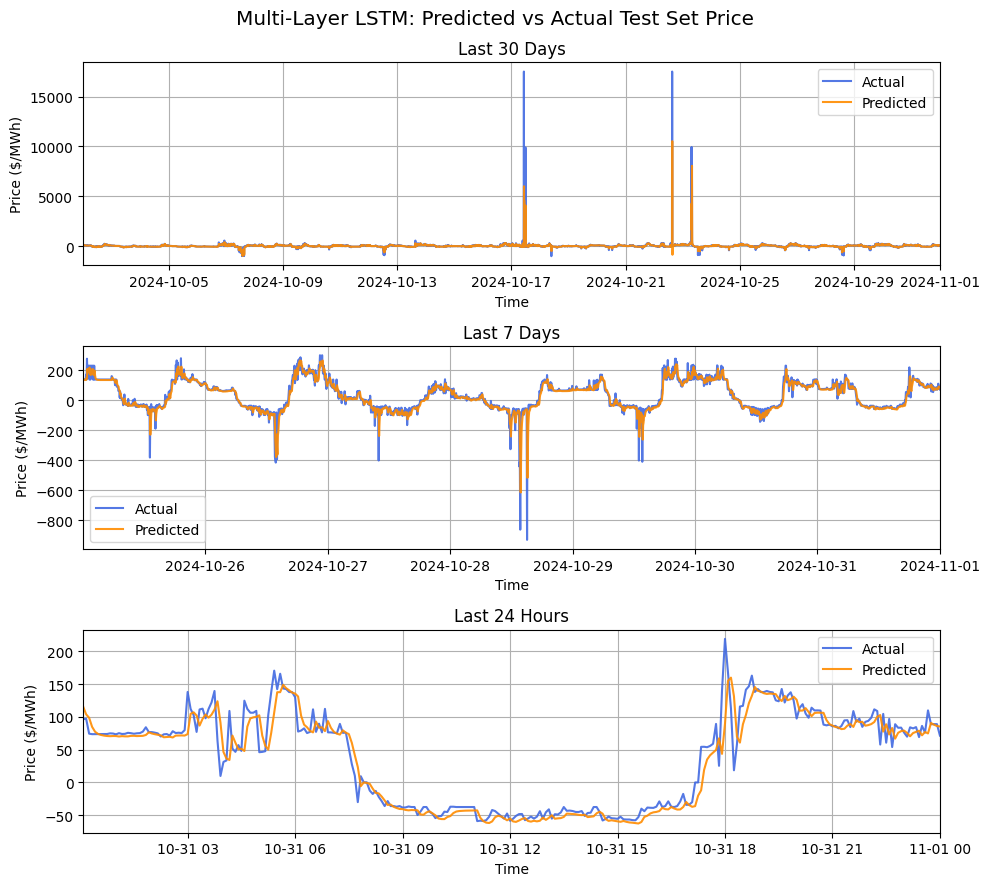

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = LSTM(input_size=m_params["input_size"],
            hidden_size=m_params["hidden_size"],
            num_layers=m_params["num_layers"],
            dropout_rate=m_params["dropout_rate"]).to(device)

epochs = m_params["epochs"]
optimizer = m_params["optimizer"](model.parameters(), lr=m_params["lr"])
loss_fn = m_params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_lstm_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-6, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"Multi-Layer LSTM")

# Evaluate Model
m_lstm_results, m_lstm_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"Multi-Layer LSTM")

## 5.6 Multi-Layer GRU

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.01172 || Validation Loss: 0.0009673 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 2 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001621 || Validation Loss: 0.0008335 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 3 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001421 || Validation Loss: 0.0008607 

Epoch: 4 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001313 || Validation Loss: 0.0008245 

Epoch: 5 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001185 || Validation Loss: 0.0007828 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 6 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001118 || Validation Loss: 0.0007659 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 7 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001084 || Validation Loss: 0.0007646 

Epoch: 8 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.001009 || Validation Loss: 0.0008171 

Epoch: 9 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009865 || Validation Loss: 0.0008049 

Epoch: 10 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009456 || Validation Loss: 0.000755 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 11 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.000958 || Validation Loss: 0.0007217 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 12 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009419 || Validation Loss: 0.0007239 

Epoch: 13 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009277 || Validation Loss: 0.0007387 

Epoch: 14 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0009103 || Validation Loss: 0.0007192 

Epoch: 15 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008876 || Validation Loss: 0.0006849 

Validation loss improved. Saving model to /content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth.
Epoch: 16 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008804 || Validation Loss: 0.0006958 

Epoch: 17 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008649 || Validation Loss: 0.0007445 

Epoch: 18 
---------


0it [00:00, ?it/s]

LR: 0.0001 || Training Loss: 0.0008806 || Validation Loss: 0.0007093 

Epoch: 19 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0008582 || Validation Loss: 0.0007247 

Epoch: 20 
---------


0it [00:00, ?it/s]

LR: 5e-06 || Training Loss: 0.0008084 || Validation Loss: 0.0007175 

Early Stopping Triggered, Stopping Training ...


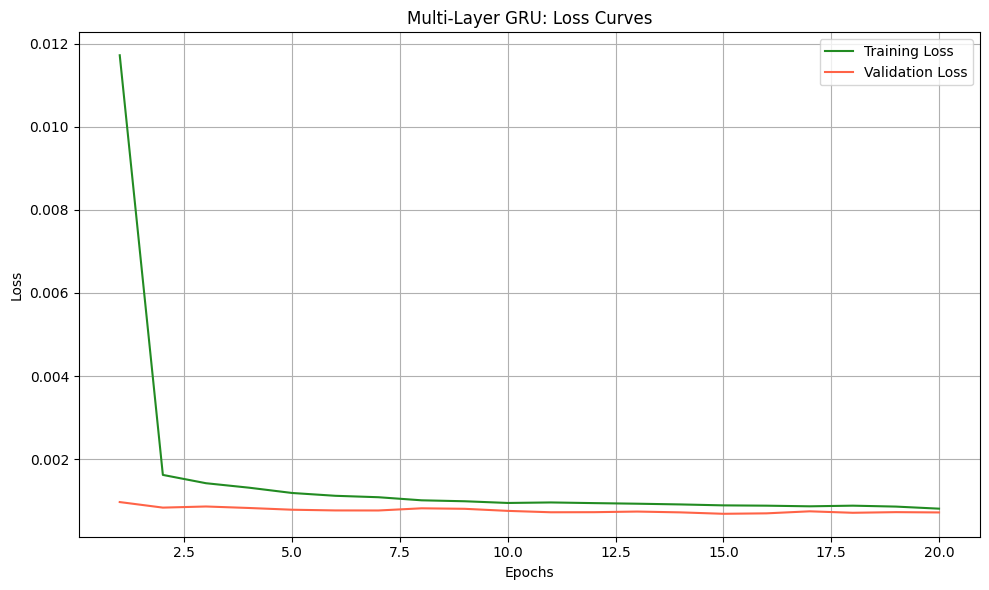

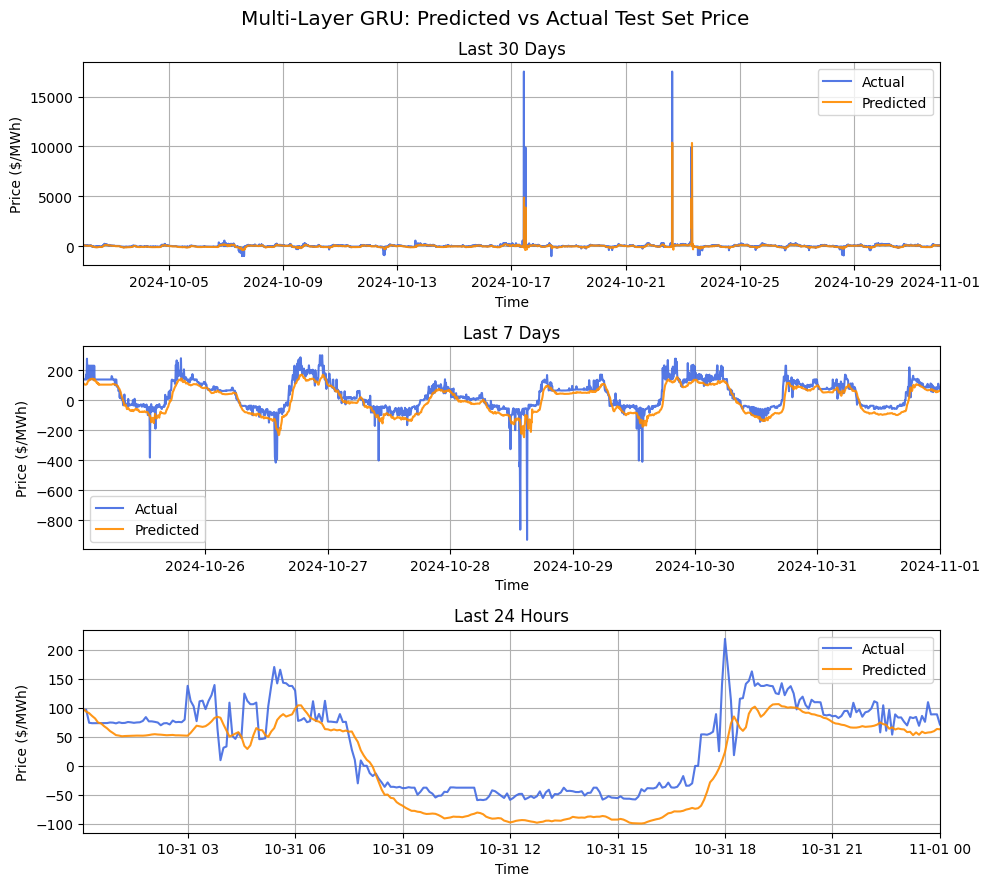

In [ ]:
# Model Training
set_seed()

# Hyperparameters from Params Dict
model = RNN(input_size=m_params["input_size"],
            hidden_size=m_params["hidden_size"],
            num_layers=m_params["num_layers"],
            dropout_rate=m_params["dropout_rate"]).to(device)

epochs = m_params["epochs"]
optimizer = m_params["optimizer"](model.parameters(), lr=m_params["lr"])
loss_fn = m_params["loss_fn"]

# Early Stopping
model_path = "/content/drive/MyDrive/Datasets/sa_electricity/Models/final_m_gru_model.pth"
early_stopping = EarlyStopping(patience=5, delta=1e-5, save_path=model_path)

# LR Scheduler
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.05, patience=3, threshold = 1e-6)

# Training Loss Vectors
train_loss = list()
val_loss = list()

# Training Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n---------")
    train_loss.append(train_loop(model=model,
                                  train_loader=train_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  device=device))
    val_loss.append(val_loop(model=model,
                              val_loader=val_loader,
                              loss_fn=loss_fn,
                              device=device))
    # LR Scheduling
    lr_sched.step(val_loss[-1])

    print(f"LR: {optimizer.param_groups[0]['lr']} || Training Loss: {train_loss[-1]:.4} || Validation Loss: {val_loss[-1]:.4} \n")

    # Check/Trigger Early Stopping
    early_stopping(val_loss[-1], model)
    if early_stopping.early_stop:
        print("Early Stopping Triggered, Stopping Training ...")
        break

# Loading Best Model
model.load_state_dict(torch.load(model_path, weights_only=True))

# Plot Loss Curves
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, model_string=f"Multi-Layer GRU")

# Evaluate Model
m_gru_results, m_gru_preds = eval_loop(model = model,
        test_loader = test_loader,
        loss_fn = loss_fn,
        device = device,
        scaler = y_scaler,
        mode = 1,
        title_string = f"Multi-Layer GRU")

# Section 6: Results Comparison

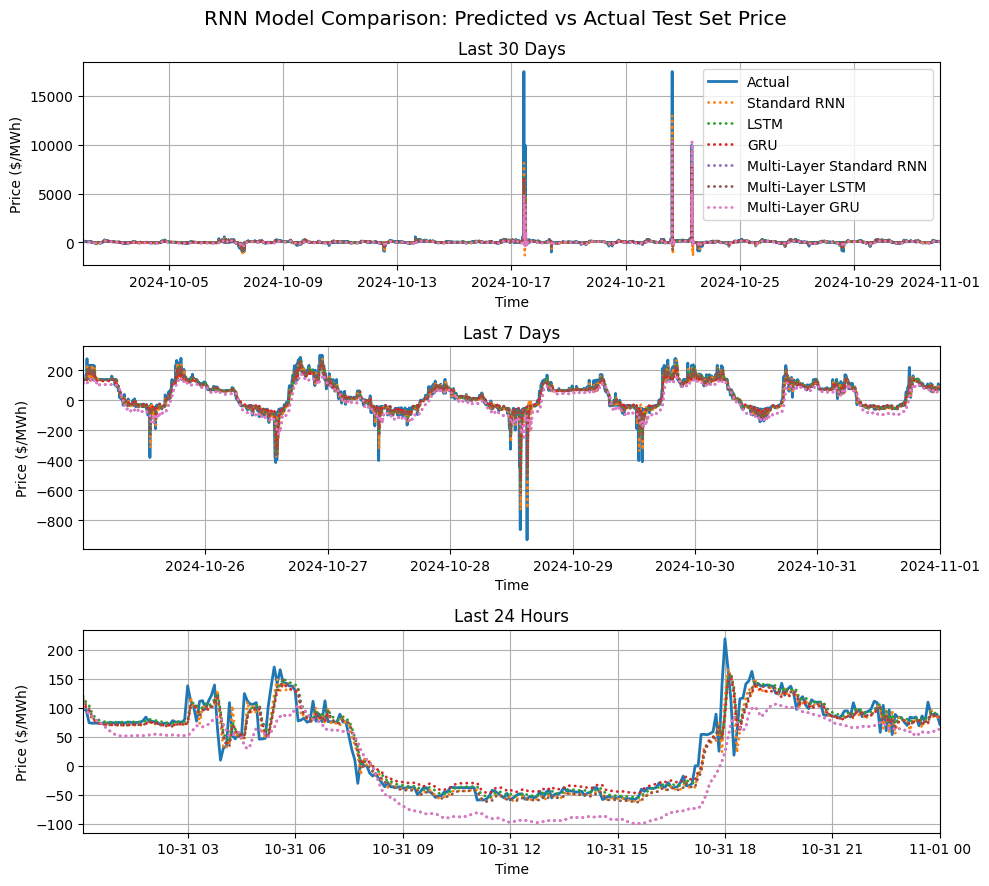

,Model,MSE Loss,Scaled MSE Loss ($/MWh),R^2,Directional Accuracy
0,Standard RNN,0.0019,34.2837,0.6262,0.3830
1,LSTM RNN,0.0018,33.4466,0.6354,0.3631
2,GRU RNN,0.0018,32.5813,0.6448,0.3611
3,Multi-Layer Standard RNN,0.0019,35.4376,0.6137,0.4176
4,Multi-Layer LSTM,0.0018,32.9552,0.6407,0.3621
5,Multi-Layer GRU,0.0019,35.4376,0.6137,0.4176


In [ ]:
# Plot All Models - Ground Truth vs Predictions
plot_predictions_model_comp({"Standard RNN": std_rnn_preds,"LSTM": lstm_rnn_preds,"GRU": gru_rnn_preds,"Multi-Layer Standard RNN": m_std_rnn_preds, "Multi-Layer LSTM": m_lstm_preds, "Multi-Layer GRU": m_gru_preds})

# Compare Performance Metrics
combined_results_df = pd.DataFrame([std_rnn_results,lstm_rnn_results,gru_rnn_results,m_std_rnn_results,m_lstm_results,m_gru_results]).reset_index(drop=True)
# combined_results_df = combined_results_df.set_index("Model")
combined_results_df